Rate: expected # bits needed to encode
<br>
Distortion: expected error in reconstruction
<br><br>
Parts of model:
 - Analysis (encoder)
 - Synthesis (Decoder)
 - Prior and entropy model (models marginal probabilities of latents)

In [2]:
!pip install "tensorflow-compression"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.5/262.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninst

In [4]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [5]:
def make_analysis_transform(latent_dims):
  return tf.keras.Sequential([
      layers.Conv2D(20, 5, use_bias=True, strides=2, padding='same',
                    activation='leaky_relu', name='conv_1'),
      layers.Conv2D(50, 5, use_bias=True, strides=2, padding='same',
                    activation='leaky_relu', name='conv_2'),
      layers.Flatten(),
      layers.Dense(500, use_bias=True, activation='leaky_relu', name='fc_1'),
      layers.Dense(latent_dims, use_bias=True, activation=None, name='fc_2')
  ], name='analysis_transform')

In [6]:
def make_synthesis_transform():
  return tf.keras.Sequential([
      layers.Dense(500, use_bias=True, activation='leaky_relu', name='fc_1'),
      layers.Dense(7*7*50, use_bias=True, activation='leaky_relu', name='fc_2'),
      layers.Reshape((7, 7, 50)),
      layers.Conv2DTranspose(20, 5, use_bias=True, strides=2, padding='same',
                             activation='leaky_relu', name='conv_1'),
      layers.Conv2DTranspose(1, 5, use_bias=True, strides=2, padding='same',
                             activation='leaky_relu', name='conv_2')
  ], name='synthesis_transform')

In [8]:
class MNISTCompressionTrainer(tf.keras.Model):
  def __init__(self, latent_dims):
    super().__init__()

    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    # prior = marginal dst of latents
    # NoisyLogistic takes into account that latents have additive noise (we add noise)
    # as scale -> 0, Logistic -> dirac delta (a spike), but our noisy dst -> uniform
    return tfc.NoisyLogistic(
      loc=0., scale=tf.exp(self.prior_log_scales)
      )

  def call(self, x, training):
    # ensure x is float in (0, 1)
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # y = latent representation
    y = self.analysis_transform(x)

    # perturb and model entropy of y

    # latents will be quantized at test time, model this during training by adding uniform noise in (-0.5, 0.5)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        # adds uniform noise & computes a differentiable upperbound on rate
        # the bound is minimized during training
        self.prior, coding_rank=1, compression=False
    )
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)  # reconstruct

    rate = tf.reduce_mean(rate)
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)

In [9]:
train_dataset, val_dataset = tfds.load(
    'mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=False
    )

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Check above things individually

dtype: uint8, Shape: (28, 28, 1)


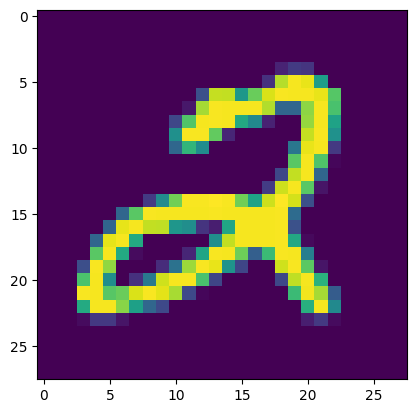

In [20]:
x_iter = val_dataset.take(1)
for x_cur in x_iter.as_numpy_iterator():
  (x, _) = x_cur

plt.imshow(tf.squeeze(x))
print(f"dtype: {x.dtype}, Shape: {x.shape}")

In [24]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)
print(y)

y_tilde = y + tf.random.uniform(y.shape, -.5, .5)
print(y_tilde)

tf.Tensor(
[[-9.3610640e-07  1.5926297e-06 -1.5996668e-06 -1.2753310e-06
   7.7287194e-07 -2.4167034e-07 -8.4184956e-07 -5.0027488e-08
  -7.3256274e-07  1.0189849e-06]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[ 0.36733666  0.07929032  0.3268413   0.19238272  0.23116249  0.2630242
  -0.02286232 -0.28557056 -0.38698974  0.44083017]], shape=(1, 10), dtype=float32)


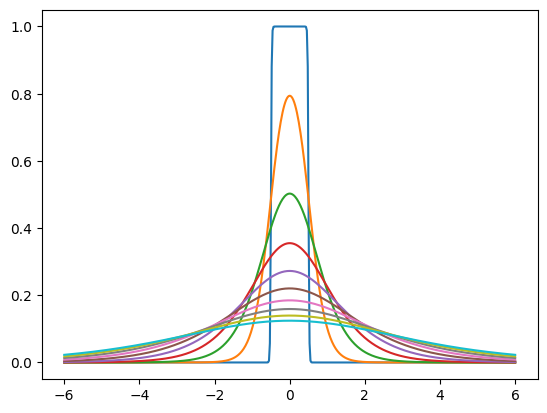

In [25]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))
_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_))  # approaches uniform

In [26]:
entropy_model = tfc.ContinuousBatchedEntropyModel(prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)
print(rate)
print(y_tilde)

tf.Tensor([18.155743], shape=(1,), dtype=float32)
tf.Tensor(
[[ 0.01426889  0.00294094 -0.31298095  0.36823288 -0.20429772  0.41072357
  -0.42389894 -0.21897893 -0.21584608  0.35572368]], shape=(1, 10), dtype=float32)


tf.Tensor(0.0015704964, shape=(), dtype=float32)
Dtype: <dtype: 'uint8'>, Shape: (28, 28, 1)


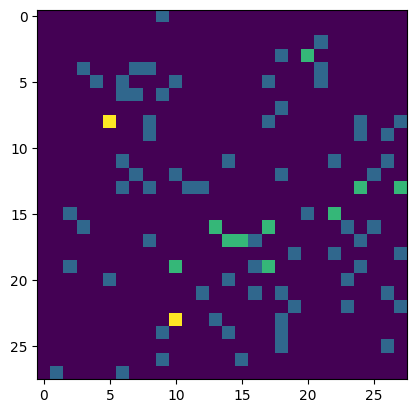

In [27]:
x_tilde = make_synthesis_transform()(y_tilde)

distortion = tf.reduce_mean(abs(x - x_tilde))
print(distortion)

x_tilde = tf.saturate_cast(x_tilde[0]*255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Dtype: {x_tilde.dtype}, Shape: {x_tilde.shape}")

In [30]:
example_batch_iter = val_dataset.batch(32).take(1)
for ex in example_batch_iter:
  (example_batch, _) = ex
trainer = MNISTCompressionTrainer(10)
example_out = trainer(example_batch)

print(example_out['rate'], example_out['distortion'])

tf.Tensor(20.296253, shape=(), dtype=float32) tf.Tensor(0.14659302, shape=(), dtype=float32)


 - train = optimize rate-distortion Lagrangian
  -   (sum of rate and distortion, where one is weighted by Lagrange parameter "lambda")

- analysis_transform is trained to achieve  desired trade-off
- synthesis_transform is trained to minimize distortion, given the latent
- prior is trained to minimize rate, given latent (fitting prior to marginal dst of latents)


In [31]:
def pass_through_loss(_, x):
  return x

def make_mnist_compression_trainer(lambda_, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      # this is unsupervised, so use pass_through_loss
      loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
      metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
      loss_weights=dict(rate=1., distortion=lambda_)
  )

  return trainer

In [34]:
def add_rate_distortion_targets(img, label):
  # is unsupervised but need to add dummy targets
  return img, dict(rate=0., distortion=0.)

def train_mnist_model(lambda_):
  trainer = make_mnist_compression_trainer(lambda_)
  trainer.fit(
      train_dataset.map(add_rate_distortion_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=val_dataset.map(add_rate_distortion_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1
  )

  return trainer

In [35]:
trainer = train_mnist_model(2000)

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 221.2666 - distortion_loss: 0.0608 - rate_loss: 99.6147 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 99.6100

469/469 [==============================] - 115s 237ms/step - loss: 221.2666 - distortion_loss: 0.0608 - rate_loss: 99.6147 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 99.6100 - val_loss: 178.2723 - val_distortion_loss: 0.0435 - val_rate_loss: 91.1825 - val_distortion_pass_through_loss: 0.0435 - val_rate_pass_through_loss: 91.1912
Epoch 2/15
469/469 [==============================] - 128s 274ms/step - loss: 166.2452 - distortion_loss: 0.0413 - rate_loss: 83.6880 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 83.6837 - val_loss: 157.0995 - val_distortion_loss: 0.0411 - val_rate_loss: 74.9837 - val_distortion_pass_through_loss: 0.0411 - val_rate_pass_through_loss: 74.9858
Epoch 3/15
469/469 [==============================] - 105s 223ms/step - loss: 151.2901 - distortion_loss: 0.0401 - rate_loss: 71.0156 - distortion_pass_through_loss: 0.0401 - rate_pass_through_loss: 71.0129 - val_loss: 144.4142 - val_distortion_loss: 0.0403 - val_rate_loss: 63.8599 

Compression: Encoder (Analysis transform + Entropy Model)
<br>
Decompression: - Decoder (Synthesis transform + Entropy Model)

In [36]:
class MNISTCompressor(tf.keras.Model):
  def __init__(self, analysis_transform, entropy_model):
    super().__init__()

    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    _, bits = self.entropy_model(y, training=False)

    return self.entropy_model.compress(y), bits


class MNISTDecompressor(tf.keras.Model):
  def __init__(self, synthesis_transform, entropy_model):
    super().__init__()

    self.synthesis_transform = synthesis_transform
    self.entropy_model = entropy_model

  def call(self, string):
    # call the latents x_hat and the reconstruction y_hat, cuz they're sort of different compared to training (they don't have additive noise, they're quantized + compressed)
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)

    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

In [37]:
def make_mnist_codec(trainer, **kwargs):
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      # compression=True means convert prior into tables for a range coding algo, which converts latent into bit seqs when we call compress()
      # len of each binary str approximates the info content of the latent (-ve log-likelihood of latent under prior)
      trainer.prior, coding_rank=1, compression=True, **kwargs
  )

  # need to share entropy_model, else decoding errors can occur
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(trainer.synthesis_transform, entropy_model)

  return compressor, decompressor

In [38]:
compressor, decompressor = make_mnist_codec(trainer)

In [39]:
originals = None
for cur in val_dataset.batch(16).skip(3).take(1):
  (originals, _) = cur

strs, entropies = compressor(originals)
print(f"Str rep of 1st digit in hex: 0x{strs[0].numpy().hex()}")
print(f"No. bits actually needed to represent it: {entropies[0]:0.2f}")

Str rep of 1st digit in hex: 0xa5e8e2d82882
No. bits actually needed to represent it: 42.21


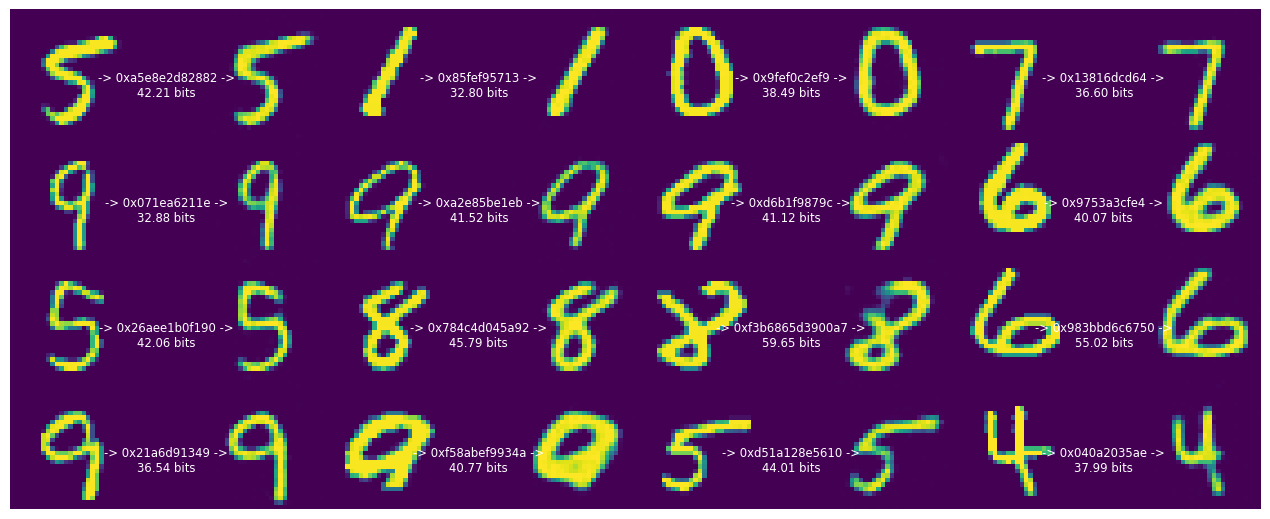

In [43]:
def display_digits(originals, strs, entropies, reconstrs):
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()

  for i in range(len(axes)):
    img = tf.concat(values=[
        tf.squeeze(originals[i]),
        tf.zeros(shape=(28, 14), dtype=tf.uint8),
        tf.squeeze(reconstrs[i])
    ], axis=1)

    axes[i].imshow(img)
    axes[i].text(
        .5, .5, f"-> 0x{strs[i].numpy().hex()} ->\n{entropies[i]:0.2f} bits",
        ha='center', va='top', color='white', fontsize='small',
        transform=axes[i].transAxes
    )
    axes[i].axis('off')

  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


reconstrs = decompressor(strs)

display_digits(originals, strs, entropies, reconstrs)

In [ ]:
# to check effect of multiple values of lambda (trade-off)
def train_visualize_model(lambda_):
  trainer = train_mnist_model(lambda_)
  compressor, decompressor = make_mnist_codec(trainer)
  strs, entropies = compressor(originals)
  reconstrs = decompressor(strs)
  display_digits(originals, strs, entropies, reconstrs)

In [ ]:
train_and_visualize_model(500)

In [ ]:
train_and_visualize_model(300)

In [ ]:
train_and_visualize_model(50)

Decompressor can be used as a Generative Model (feed it random latents)

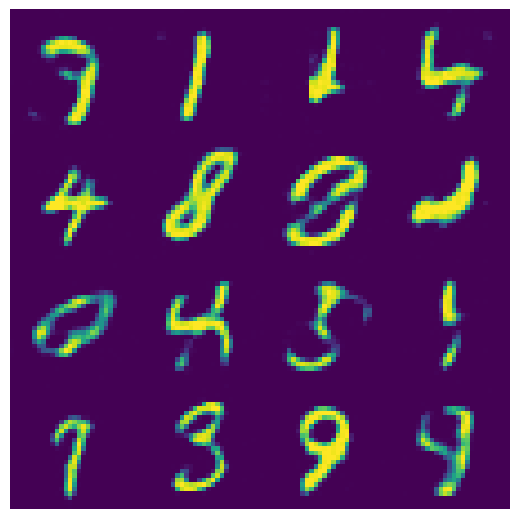

In [44]:
compressor, decompressor = make_mnist_codec(
    trainer,
    decode_sanity_check=False  # don't check if input string isn't completely decoded
    )

import os

strs = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strs)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)